In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [14]:
# read data
data = pd.read_csv("alzheimers_disease_data.csv")
data.shape

(2149, 35)

In [16]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Step 1: Select the nominal categorical features
nominal_features = ['Ethnicity', 'EducationLevel']

# Step 2: Initialize One-Hot Encoder without dropping any category
ohe = OneHotEncoder(drop=None, sparse_output=False)  # Keep all categories

# Step 3: Fit and transform the categorical features
encoded_features = ohe.fit_transform(data[nominal_features])

# Step 4: Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(nominal_features))

# Step 5: Drop the original categorical columns and merge encoded features
data = data.drop(columns=nominal_features).reset_index(drop=True)  # Drop original categorical columns
data = pd.concat([data, encoded_df], axis=1)  # Merge encoded data

# Step 6: Verify the transformed data
print("Updated Dataset After One-Hot Encoding:")
print(data.head())


Updated Dataset After One-Hot Encoding:
   PatientID  Age  Gender        BMI  Smoking  AlcoholConsumption  \
0       4751   73       0  22.927749        0           13.297218   
1       4752   89       0  26.827681        0            4.542524   
2       4753   73       0  17.795882        0           19.555085   
3       4754   74       1  33.800817        1           12.209266   
4       4755   89       0  20.716974        0           18.454356   

   PhysicalActivity  DietQuality  SleepQuality  FamilyHistoryAlzheimers  ...  \
0          6.327112     1.347214      9.025679                        0  ...   
1          7.619885     0.518767      7.151293                        0  ...   
2          7.844988     1.826335      9.673574                        1  ...   
3          8.428001     7.435604      8.392554                        0  ...   
4          6.310461     0.795498      5.597238                        0  ...   

   Diagnosis  DoctorInCharge  Ethnicity_0  Ethnicity_1  Ethnicit

In [18]:
selected_features = [
    'FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems', 'SleepQuality',
    'CholesterolHDL', 'Ethnicity_2', 'Hypertension', 'Ethnicity_1', 'CholesterolLDL', 'Diabetes',
    'EducationLevel_3', 'BMI', 'Ethnicity_3', 'Disorientation', 'CholesterolTriglycerides',
    'AlcoholConsumption', 'Forgetfulness', 'PersonalityChanges', 'Gender'
]

In [20]:
X = data[selected_features]  
y = data['Diagnosis']

In [22]:
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data and transform both train and test separately
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

## DT

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_scaled, y_train)

dt_y_pred = dt.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, dt_y_pred))
print("Classification Report:\n", classification_report(y_test, dt_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_y_pred))

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       277
           1       0.88      0.83      0.86       153

    accuracy                           0.90       430
   macro avg       0.90      0.88      0.89       430
weighted avg       0.90      0.90      0.90       430

Confusion Matrix:
 [[260  17]
 [ 26 127]]


## RF

Accuracy: 0.942

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       277
           1       0.96      0.87      0.91       153

    accuracy                           0.94       430
   macro avg       0.95      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430


Confusion Matrix:
 [[272   5]
 [ 20 133]]


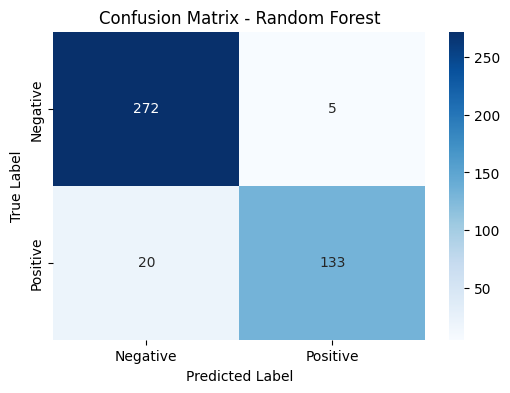

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # 100 trees in the forest

# Train the model
rf.fit(X_train_scaled, y_train)

# Make predictions
rf_y_pred = rf.predict(X_test_scaled)

# Print evaluation metrics
print("Accuracy:", f"{accuracy_score(y_test, rf_y_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))


## XGBoost

## Catboost